# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [44]:
# import libraries
import datetime
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnan, when, count, col, row_number
from pyspark.sql.types import IntegerType, TimestampType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [45]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [46]:
events = spark.read.json("mini_sparkify_event_data.json")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### First Glance at the Data

In [4]:
events.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
events.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [6]:
events.dtypes # data types

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string')]

In [262]:
# let's see what we get as general statistics already
events.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+--------------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|               churn|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+--------------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|       

In [256]:
# here need to look at portion of null values

In [103]:
# let's look at some entries for one specific user
events.select(["userId", "firstname", "page", "song", "level"]).where(events.userId == "30").collect()

[Row(userId='30', firstname='Colin', page='NextSong', song='Rockpools', level='paid'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Time For Miracles', level='paid'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Harder Better Faster Stronger', level='paid'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Passengers (Old Album Version)', level='paid'),
 Row(userId='30', firstname='Colin', page='Add to Playlist', song=None, level='paid'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Fuck Kitty', level='paid'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Jade', level='paid'),
 Row(userId='30', firstname='Colin', page='NextSong', song='So-Called Friends', level='paid'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Represent', level='paid'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Here I Am', level='paid'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Rebirthing (Album

In [20]:
# inspect the userIds
events.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



The userId contains values with an empty string. These entries need to be removed.

In [51]:
# events where a userId is an empty string are not valid, remove these
valid_events = events.where(col("userId") != "")
print("Number of total events: {}; number of valid events {}".format(events.count(), valid_events.count()))

Number of total events: 286500; number of valid events 278154


In [23]:
# inspect page options
valid_events.select("page").dropDuplicates().sort("page").collect()

[Row(page='About'),
 Row(page='Add Friend'),
 Row(page='Add to Playlist'),
 Row(page='Cancel'),
 Row(page='Cancellation Confirmation'),
 Row(page='Downgrade'),
 Row(page='Error'),
 Row(page='Help'),
 Row(page='Home'),
 Row(page='Login'),
 Row(page='Logout'),
 Row(page='NextSong'),
 Row(page='Register'),
 Row(page='Roll Advert'),
 Row(page='Save Settings'),
 Row(page='Settings'),
 Row(page='Submit Downgrade'),
 Row(page='Submit Registration'),
 Row(page='Submit Upgrade'),
 Row(page='Thumbs Down'),
 Row(page='Thumbs Up'),
 Row(page='Upgrade')]

The page column contains the cancellation confirmation.

In [25]:
# inspect gender options
valid_events.select("gender").dropDuplicates().sort("gender").collect()

[Row(gender='F'), Row(gender='M')]

In [26]:
# inspect level values
valid_events.select("level").dropDuplicates().sort("level").collect()

[Row(level='free'), Row(level='paid')]

In [47]:
# registration and ts can both be converted to timestamps
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0), TimestampType()) # udf to convert to timestamp/date

In [52]:
valid_events = valid_events.withColumn("registration_date", get_date(col("registration"))) # date for registration
valid_events.select("registration_date").show()

+-------------------+
|  registration_date|
+-------------------+
|2018-09-29 00:22:42|
|2018-09-30 20:20:30|
|2018-09-29 00:22:42|
|2018-09-30 20:20:30|
|2018-09-29 00:22:42|
|2018-09-30 20:20:30|
|2018-09-30 20:20:30|
|2018-09-29 00:22:42|
|2018-09-29 00:22:42|
|2018-09-29 00:22:42|
|2018-09-30 20:20:30|
|2018-09-30 20:20:30|
|2018-09-29 00:22:42|
|2018-09-30 20:20:30|
|2018-09-30 20:20:30|
|2018-09-29 00:22:42|
|2018-09-30 20:20:30|
|2018-09-19 15:53:39|
|2018-09-29 00:22:42|
|2018-09-30 20:20:30|
+-------------------+
only showing top 20 rows



In [53]:
valid_events = valid_events.withColumn("log_date", get_date(col("ts"))) # date when the log entry was done
valid_events.select("log_date").show()

+-------------------+
|           log_date|
+-------------------+
|2018-10-01 02:01:57|
|2018-10-01 02:03:00|
|2018-10-01 02:06:34|
|2018-10-01 02:06:56|
|2018-10-01 02:11:16|
|2018-10-01 02:11:18|
|2018-10-01 02:14:46|
|2018-10-01 02:14:59|
|2018-10-01 02:15:05|
|2018-10-01 02:18:04|
|2018-10-01 02:19:06|
|2018-10-01 02:19:10|
|2018-10-01 02:20:18|
|2018-10-01 02:22:55|
|2018-10-01 02:22:56|
|2018-10-01 02:24:01|
|2018-10-01 02:26:16|
|2018-10-01 02:27:48|
|2018-10-01 02:28:07|
|2018-10-01 02:29:04|
+-------------------+
only showing top 20 rows



In [31]:
# inspect the status values
valid_events.select("status").dropDuplicates().sort("status").collect()

[Row(status=200), Row(status=307), Row(status=404)]

In [264]:
valid_events.where(col("status") == 404).take(5)

[Row(artist=None, auth='Logged In', firstName='Kael', gender='M', itemInSession=48, lastName='Baker', length=None, level='paid', location='Kingsport-Bristol-Bristol, TN-VA', method='GET', page='Error', registration=1533102330000, sessionId=249, song=None, status=404, ts=1538393848000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"', userId='131', churn=0, registration_date=datetime.datetime(2018, 8, 1, 7, 45, 30), log_date=datetime.datetime(2018, 10, 1, 13, 37, 28), log_event_year=2018, log_event_month=10),
 Row(artist=None, auth='Logged In', firstName='Lucero', gender='F', itemInSession=10, lastName='Reed', length=None, level='free', location='Louisville/Jefferson County, KY-IN', method='GET', page='Error', registration=1536642109000, sessionId=139, song=None, status=404, ts=1538407927000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari

Status 404 actually seems to be an error. That is also what the page value indicates.

In [266]:
valid_events.where(col("status") == 307).take(5)

23184

In [267]:
valid_events.select("status") \
     .groupBy("status") \
     .agg({'status' : 'count'}) \
     .withColumnRenamed('count(status)', 'Statuscount') \
     .sort(desc('Statuscount')) \
     .show()

+------+-----------+
|status|Statuscount|
+------+-----------+
|   200|     254718|
|   307|      23184|
|   404|        252|
+------+-----------+



Status:
- 404: Page not found
- 307: Temporary redirect
- 200: OK

In [268]:
# inspect the length values
valid_events.select("length").dropDuplicates().sort("length").show(30)

+--------+
|  length|
+--------+
|    null|
| 0.78322|
| 2.16771|
| 4.04853|
|  4.8322|
|  6.3473|
| 7.83628|
| 8.30649|
| 9.01179|
|10.03057|
|10.52689|
|11.20608|
|11.25832|
|11.36281|
|11.49342|
|11.54567|
|11.93751|
|11.98975|
|12.22485|
|12.30322|
|12.43383|
|12.64281|
|12.66893|
|12.69506|
|13.16526|
|13.42649|
|13.63546|
|13.68771|
|13.92281|
|14.96771|
+--------+
only showing top 30 rows



In [269]:
# statistics about the length
valid_events.select("length").describe().show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



In [49]:
# when is the length null
valid_events.where(col("length").isNull()).show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+-----+-------------------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|churn|  registration_date|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+-----+-------------------+
|  null|Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|    0|2018-09-29 00:22:42|
|  null|Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|15383

In [51]:
# are there entries where the log contains null for the length but the artist is not null
valid_events.where(col("artist").isNotNull() & col("length").isNull()).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+-----+-----------------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|churn|registration_date|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+-----+-----------------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+-----+-----------------+



In [52]:
# what action happend when the length is not null
valid_events.where(col("length").isNotNull()).groupBy("page").count().show()

+--------+------+
|    page| count|
+--------+------+
|NextSong|228108|
+--------+------+



This illustrates that the length clearly describes how long the user listened to a specific song.

In [58]:
# let's look at the artists and songs
valid_events.select("artist").dropDuplicates().sort("artist").show(30)

+--------------------+
|              artist|
+--------------------+
|                null|
|                 !!!|
|        & And Oceans|
|'N Sync/Phil Collins|
|        'Til Tuesday|
| 't Hof Van Commerce|
|'t Hof Van Commer...|
|       (Love) Tattoo|
|          (hed) p.e.|
|*NSYNC featuring ...|
|  + / - {Plus/Minus}|
|                 +44|
|          -123 minut|
|            -123min.|
|       ...And Oceans|
|...And You Will K...|
|           1 40 4 20|
|1 Giant Leap feat...|
|1 Giant Leap feat...|
|1 Giant Leap feat...|
|1 Giant Leap feat...|
|1 Giant Leap feat...|
|            10 Years|
|       10000 Maniacs|
|           1000names|
|                1001|
|                 108|
|      10_000 Maniacs|
|                10cc|
|                 112|
+--------------------+
only showing top 30 rows



In [60]:
valid_events.filter(col("artist") == "!!!").show()

+------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+----------------+------+-------------+--------------------+------+-----+-------------------+
|artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|            song|status|           ts|           userAgent|userId|churn|  registration_date|
+------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+----------------+------+-------------+--------------------+------+-----+-------------------+
|   !!!|Logged In|    Faigy|     F|          319|    Howe|294.94812| paid|Phoenix-Mesa-Scot...|   PUT|NextSong|1538211832000|      398|      A New Name|   200|1538653371000|Mozilla/5.0 (Maci...|    95|    0|2018-09-29 11:03:52|
|   !!!|Logged In|  Nikolas|     M|           12|   Olsen|356.10077| paid|Oxnard-Thousan

"!!!" is really an artist. You can look it up on spotify (https://open.spotify.com/artist/1mmehjf7eHA10uHMisZGJg).

In [61]:
valid_events.select("song").dropDuplicates().sort("song").show(30)

+--------------------+
|                song|
+--------------------+
|                null|
|ÃÂg ÃÂtti Gr...|
| I Will Not Reap ...|
|              !@*$%#|
|#!*@ You Tonight ...|
|                  #1|
|#1 Fan [Feat. Key...|
|           #1 Stunna|
|                 #16|
| #18 (Album Version)|
|#2 For Prepared W...|
|                 #24|
|  #4 (Album Version)|
|                 #40|
|                   $|
|       $1000 Wedding|
|$87 And A Guilty ...|
|                $in$|
|       $timulus Plan|
|              & Down|
|&And The Battle B...|
|&And The Day Turn...|
|&And The World Wi...|
|&and She Told Me ...|
|        ' Cello Song|
|           '60 - '65|
|  '97 Bonnie & Clyde|
|            'A Cimma|
|'Allo 'Allo (Orig...|
|  'Elepaio Slack Key|
+--------------------+
only showing top 30 rows



Songs and artist contain null values as expected but no further processing necessary here.

In [64]:
# firstName, lastName
valid_events.select("firstName").dropDuplicates().sort("firstName").show(30)

+----------+
| firstName|
+----------+
|  Adelaida|
|    Adrian|
|   Adriana|
|    Adriel|
|   Ainsley|
|      Alex|
| Alexander|
|Alexandria|
|     Alexi|
|    Alyssa|
|   Alyssia|
| Amberlynn|
|    Andrew|
|     Angel|
|     Anika|
|      Anna|
| Annabella|
|  Antonina|
|   Antonio|
|      Aron|
|   Ashlynn|
|    Aurora|
|    Autumn|
|       Ava|
|    Azrael|
|  Benjamin|
|    Bianca|
|   Brayden|
|     Brisa|
|    Brooke|
+----------+
only showing top 30 rows



In [63]:
# any null values for first or last name
valid_events.where(col("firstName").isNull() | col("lastName").isNull()).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+-----+-----------------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|churn|registration_date|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+-----+-----------------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+-----+-----------------+



First and last name do not contain any null values. 

In [65]:
# inspect the auth data
valid_events.select("auth").dropDuplicates().sort("auth").show(30)

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [77]:
# how do the logs look for the case that auth is cancelled
valid_events.filter(col("auth") == "Cancelled").show()

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-----+-------------------+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|churn|  registration_date|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-----+-------------------+
|  null|Cancelled|   Adriel|     M|          104|  Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|    1|2018-08-30 12:04:26|
|  null|Cancelled|    Diego|     M|           56|    Mckee|  null| paid|Phoenix-Mesa-Scot...|   

In [78]:
valid_events.filter(col("auth") == "Cancelled").filter(col("page") != "Cancellation Confirmation").show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+-----+-----------------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|churn|registration_date|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+-----+-----------------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+-----+-----------------+



If the cancellation is confirmed, the authentication is set to "cancelled".

In [66]:
# what do we get for the method values
valid_events.select("method").dropDuplicates().sort("method").show(30)

+------+
|method|
+------+
|   GET|
|   PUT|
+------+



### Data Exploration
Now we define a variable for churn and also look into the data to find any differences between the users who churned and the ones who did not.

In [56]:
# add a column "churn" to the dataframe indicating that a cancellation was confirmed
find_churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
valid_events = valid_events.withColumn("churn", find_churn(col("page")))
valid_events[["page", "churn"]].where(valid_events.churn == 1).show()

+--------------------+-----+
|                page|churn|
+--------------------+-----+
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
+--------------------+-----+
only showing top 20 rows



In [136]:
find_downgrade = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
valid_events = valid_events.withColumn("downgrade_event", find_downgrade(col("page")))
valid_events[["page", "downgrade_event"]].where(valid_events.downgrade_event == 1).show()

+----------------+---------------+
|            page|downgrade_event|
+----------------+---------------+
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
|Submit Downgrade|              1|
+----------------+---------------+
only showing top 20 rows



In [137]:
agg_users = valid_events.groupBy("userId").agg({"churn": "sum", "downgrade_event": "sum"}).withColumnRenamed("sum(churn)", "churned").withColumnRenamed("sum(downgrade_event)", "downgraded")
        

In [138]:
agg_users.describe().show()

+-------+------------------+------------------+------------------+
|summary|            userId|        downgraded|           churned|
+-------+------------------+------------------+------------------+
|  count|               225|               225|               225|
|   mean|65391.013333333336|              0.28|0.2311111111111111|
| stddev|105396.47791907164|0.5876709477736184|0.4224832108996327|
|    min|                10|                 0|                 0|
|    max|                99|                 3|                 1|
+-------+------------------+------------------+------------------+



In [140]:
# showing how many users churned
agg_users.groupBy("churned").count().show()

+-------+-----+
|churned|count|
+-------+-----+
|      0|  173|
|      1|   52|
+-------+-----+



In [141]:
agg_users.groupBy(["downgraded", "churned"]).count().show()

+----------+-------+-----+
|downgraded|churned|count|
+----------+-------+-----+
|         3|      0|    2|
|         1|      0|   28|
|         1|      1|    9|
|         0|      1|   43|
|         2|      0|   10|
|         0|      0|  133|
+----------+-------+-----+



There are 52 different users out of 225 which churned. This is an **imbalanced dataset!**

From the users who churned, most of them never downgraded. This means ???

In [145]:
user_length = valid_events.groupBy("userId").agg({"churn": "sum", "length": "mean"}).withColumnRenamed("avg(length)", "avg_length")


DataFrame[summary: string, userId: string, sum(churn): string, avg_length: string]

In [146]:
user_length.where(col("sum(churn)") == 1).describe().show()

+-------+-----------------+----------+------------------+
|summary|           userId|sum(churn)|        avg_length|
+-------+-----------------+----------+------------------+
|  count|               52|        52|                52|
|   mean|80808.42307692308|       1.0| 248.3078649624796|
| stddev| 86381.6770659117|       0.0| 7.703952015262295|
|    min|           100001|         1|225.18811730769232|
|    max|               87|         1|267.76714199999986|
+-------+-----------------+----------+------------------+



In [147]:
user_length.where(col("sum(churn)") == 0).describe().show()

+-------+------------------+----------+------------------+
|summary|            userId|sum(churn)|        avg_length|
+-------+------------------+----------+------------------+
|  count|               173|       173|               173|
|   mean| 60756.87861271676|       0.0|249.14125354064802|
| stddev|110276.04376677402|       0.0| 5.312185141455677|
|    min|                10|         0|230.55628000000002|
|    max|                99|         0| 267.2713832911391|
+-------+------------------+----------+------------------+



In [165]:
user_length = user_length.drop("sum(churn)")

In [60]:
# investigate the distribution of the level variables
event_count = valid_events \
     .groupBy(["level", "userId"]) \
     .count()

In [88]:
event_count.show()

+-----+------+-----+
|level|userId|count|
+-----+------+-----+
| paid|   101| 2073|
| free|    43|  240|
| paid|   152| 1403|
| paid|300021| 4650|
| free|     6|   84|
| free|    52|  346|
| free|   117|  445|
| paid|200009|  543|
| free|    74|  369|
| free|    30| 1100|
| paid|   147|  467|
| free|200008|   24|
| paid|200017|  399|
| free|    87|  851|
| paid|    81| 2294|
| free|    66|  435|
| paid|   139|  421|
| paid|    42| 4128|
| paid|   106|  873|
| paid|    37| 1603|
+-----+------+-----+
only showing top 20 rows



In [272]:
event_count.groupBy("level").count().show()

+-----+-----+
|level|count|
+-----+-----+
| free|  195|
| paid|  165|
+-----+-----+



In [273]:
# how active are these differnt user groups
event_count.groupBy("level").sum().show()

+-----+----------+
|level|sum(count)|
+-----+----------+
| free|     55721|
| paid|    222433|
+-----+----------+



There are 165 paid users and 195 free users. However, there are rughly 4 times more logged events for paid users than for free users. Paid users use sparkify much more often.

In [94]:
# is there a difference in the churn rate
group_level_user = valid_events.groupBy(["userId", "level"]).agg({"churn": "sum"}).withColumnRenamed("sum(churn)", "churned")

In [95]:
group_level_user.show()

+------+-----+-------+
|userId|level|churned|
+------+-----+-------+
|100021| free|      1|
|200021| free|      0|
|200001| free|      1|
|     6| free|      0|
|300022| paid|      0|
|   132| free|      0|
|   112| free|      0|
|    79| free|      0|
|200008| free|      0|
|    16| paid|      0|
|200007| paid|      0|
|300015| free|      0|
|    39| free|      0|
|300014| paid|      0|
|    61| free|      0|
|    56| paid|      0|
|300014| free|      0|
|   100| paid|      0|
|300024| paid|      0|
|300023| paid|      0|
+------+-----+-------+
only showing top 20 rows



In [96]:
group_level_user.groupBy(["level", "churned"]).count().show()

+-----+-------+-----+
|level|churned|count|
+-----+-------+-----+
| free|      0|  174|
| paid|      0|  134|
| free|      1|   21|
| paid|      1|   31|
+-----+-------+-----+



The churning rate is higher for paid users. Users can submit a downgrade or submit an upgrade. These users can be in both groups. Hence, the sum of users in the grouped df above is higher than the number of unique user ids.

TODO: visualize the churn rates

In [188]:
# group the data also by gender
group_gender = valid_events.groupBy(["userId", "gender"]).agg({"churn": "sum"}).withColumnRenamed("sum(churn)", "churned")

+------+------+-------+
|userId|gender|churned|
+------+------+-------+
|    44|     F|      0|
|    46|     F|      0|
|    41|     F|      0|
|    72|     F|      0|
|300023|     F|      0|
|    39|     F|      0|
|100010|     F|      0|
|    40|     F|      0|
|    94|     F|      0|
|    35|     F|      0|
|    75|     F|      0|
|   116|     F|      0|
|200001|     M|      1|
|200020|     M|      1|
|100008|     F|      0|
|200015|     M|      1|
|   100|     M|      0|
|100006|     F|      1|
|300005|     F|      0|
|    25|     F|      0|
+------+------+-------+
only showing top 20 rows



In [189]:
group_gender.groupBy(["gender", "churned"]).count().show()

+------+-------+-----+
|gender|churned|count|
+------+-------+-----+
|     F|      0|   84|
|     F|      1|   20|
|     M|      0|   89|
|     M|      1|   32|
+------+-------+-----+



Almost equal distribution of the gender in both groups.

In [274]:
# NOT USED SO FAR
# some values can be set into relation to a certain time period, e.g. the duration the user is active
# therefore we define 
#get_year = udf(lambda x: x.year, IntegerType())
#get_month = udf(lambda x: x.month, IntegerType())
#valid_events = valid_events.withColumn("log_event_year", get_year(col("log_date")))
#valid_events = valid_events.withColumn("log_event_month", get_month(col("log_date")))
#valid_events.first()

In [142]:

# NEEDED HERE?
# TODO: filter for only events which indicate playing music?
# valid_events.groupBy(["userId"]).agg({"churn": "sum", "log_date": "max", "log_date": "min"}).show()

In [ ]:
# TODO: move all imports to the top

In [61]:
import pyspark.sql.functions as F 
# some values can be set into relation to a certain time period, e.g. the duration the user is active
# hence we need to create a df with all users and their active time period
# first find the first and last log entry for each user and how much log entries exist per user (all actions)
time_df = valid_events.groupBy(["userId"]).agg(F.sum("churn").alias("churned"), F.min("log_date").alias("first_log"), F.max("log_date").alias("last_log"), F.count("page").alias("log_counts"))

In [62]:
time_df.show()

+------+-------+-------------------+-------------------+----------+
|userId|churned|          first_log|           last_log|log_counts|
+------+-------+-------------------+-------------------+----------+
|100010|      0|2018-10-08 14:58:54|2018-11-21 19:12:32|       381|
|200002|      0|2018-10-01 13:30:30|2018-11-16 00:25:54|       474|
|   125|      1|2018-10-12 06:05:44|2018-10-12 06:35:18|        11|
|    51|      1|2018-10-01 14:57:12|2018-10-17 09:39:32|      2464|
|   124|      0|2018-10-01 17:17:10|2018-11-30 16:12:46|      4825|
|     7|      0|2018-10-03 13:57:49|2018-11-23 07:46:51|       201|
|    54|      1|2018-10-01 02:32:10|2018-11-12 20:40:08|      3437|
|    15|      0|2018-10-01 12:23:35|2018-11-25 05:56:58|      2278|
|   155|      0|2018-11-02 16:56:25|2018-11-28 12:48:30|      1002|
|   132|      0|2018-10-02 10:59:56|2018-11-21 21:56:12|      2304|
|   154|      0|2018-11-02 16:15:35|2018-11-27 15:56:05|       118|
|100014|      1|2018-10-10 15:12:16|2018-11-20 2

In [63]:
from dateutil import relativedelta
def get_time_difference(date_1, date_2):
    """TODO"""
    # difference between the dates
    delta = date_2 - date_1
    
    # minimum difference is one 1
    if delta.days == 0:
        return 1
    else:
        return delta.days

# create a udf for this function
get_time_difference_udf = udf(get_time_difference, IntegerType())

time_df = time_df.withColumn("duration", get_time_difference_udf(col("first_log"), col("last_log")))
time_df.show()

+------+-------+-------------------+-------------------+----------+--------+
|userId|churned|          first_log|           last_log|log_counts|duration|
+------+-------+-------------------+-------------------+----------+--------+
|100010|      0|2018-10-08 14:58:54|2018-11-21 19:12:32|       381|      44|
|200002|      0|2018-10-01 13:30:30|2018-11-16 00:25:54|       474|      45|
|   125|      1|2018-10-12 06:05:44|2018-10-12 06:35:18|        11|       1|
|    51|      1|2018-10-01 14:57:12|2018-10-17 09:39:32|      2464|      15|
|   124|      0|2018-10-01 17:17:10|2018-11-30 16:12:46|      4825|      59|
|     7|      0|2018-10-03 13:57:49|2018-11-23 07:46:51|       201|      50|
|    54|      1|2018-10-01 02:32:10|2018-11-12 20:40:08|      3437|      42|
|    15|      0|2018-10-01 12:23:35|2018-11-25 05:56:58|      2278|      54|
|   155|      0|2018-11-02 16:56:25|2018-11-28 12:48:30|      1002|      25|
|   132|      0|2018-10-02 10:59:56|2018-11-21 21:56:12|      2304|      50|

The first idea was to use months as time period, however in this data the first and last log never had a difference > 1 months.

In [64]:
# create a dummy dataframe where each action (About, Thumbs Up, ...) from page is a new column with the number
# how often this action appeared in the data for each user
dummy_df = valid_events.select("userId", "page").groupBy("userId").pivot("page").count()
# fill null values
dummy_df = dummy_df.na.fill(0)
dummy_df.first()

Row(userId='200002', About=3, Add Friend=4, Add to Playlist=8, Cancel=0, Cancellation Confirmation=0, Downgrade=5, Error=0, Help=2, Home=20, Logout=5, NextSong=387, Roll Advert=7, Save Settings=0, Settings=3, Submit Downgrade=0, Submit Upgrade=1, Thumbs Down=6, Thumbs Up=21, Upgrade=2)

In [172]:
user_df = time_df.join(dummy_df, on="userId")

In [281]:
user_df.show(2)

+------+-------+-------------------+-------------------+----------+--------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|userId|churned|          first_log|           last_log|log_counts|duration|About|Add Friend|Add to Playlist|Cancel|Cancellation Confirmation|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|
+------+-------+-------------------+-------------------+----------+--------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|100010|      0|2018-10-08 14:58:54|2018-11-21 19:12:32|       381|      44|    1|         4|              7|  null|                     null|     null| n

In [282]:
user_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churned: long (nullable = true)
 |-- first_log: timestamp (nullable = true)
 |-- last_log: timestamp (nullable = true)
 |-- log_counts: long (nullable = false)
 |-- duration: integer (nullable = true)
 |-- About: long (nullable = true)
 |-- Add Friend: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- Cancel: long (nullable = true)
 |-- Cancellation Confirmation: long (nullable = true)
 |-- Downgrade: long (nullable = true)
 |-- Error: long (nullable = true)
 |-- Help: long (nullable = true)
 |-- Home: long (nullable = true)
 |-- Logout: long (nullable = true)
 |-- NextSong: long (nullable = true)
 |-- Roll Advert: long (nullable = true)
 |-- Save Settings: long (nullable = true)
 |-- Settings: long (nullable = true)
 |-- Submit Downgrade: long (nullable = true)
 |-- Submit Upgrade: long (nullable = true)
 |-- Thumbs Down: long (nullable = true)
 |-- Thumbs Up: long (nullable = true)
 |-- Upgrade: long (nullable = t

In [66]:
# for visualization, convert to pandas df
user_pd = user_df.toPandas()
churned = user_pd[user_pd["churned"] == 1] # users who churned
not_churned = user_pd[user_pd["churned"] == 0] # users who did not

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

def create_hist_for_groups(churn_values, not_churn_values, x_label, ax1, ax2):
    """TODO!!!"""
    # mean values
    mean_churn = churn_values.mean()
    mean_not_churn = not_churn_values.mean()
    # histogram for churn values
    ax1.hist(churn_values, density=True)
    ax1.axvline(mean_churn, color='g', linestyle='dashed', linewidth=1, label="mean")
    ax1.set_xlabel(x_label)
    ax1.set_ylabel("Normalized Count")
    ax1.set_title("Churned")
    ax1.legend()
    ax2.hist(not_churn_values, density=True)
    ax2.axvline(mean_not_churn, color='g', linestyle='dashed', linewidth=1, label="mean")
    ax2.set_xlabel(x_label)
    ax2.set_ylabel("Normalized Count")
    ax2.set_title("Not Churned")
    ax2.legend()
    
    return ax1, ax2, mean_churn, mean_not_churn

In [32]:
len(user_pd.columns) - 2 

23

In [121]:
n_vars = 23 # need 2* 23 plots = 46
user_pd.drop(["Cancel", "Cancellation Confirmation"], inplace=True, axis=1)
var_names = user_pd.columns[4:]
var_names

Index(['log_counts', 'duration', 'About', 'Add Friend', 'Add to Playlist',
       'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong',
       'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade',
       'Submit Upgrade', 'Thumbs Down', 'Thumbs Up', 'Upgrade'],
      dtype='object')

In [123]:
def divide_by(df, columns, value):
    df_per = df.copy()
    for name in columns:
        df_per[name+"_per_"+str(value)] = df_per[name] / df_per[value]
    # df_per.drop(columns, axis=1, inplace=True)
    return df_per

user_per = divide_by(user_pd, ['About', 'Add Friend', 'Add to Playlist',
       'Downgrade', 'Error', 'Help',
       'Home', 'Logout', 'NextSong', 'Roll Advert', 'Save Settings',
       'Settings', 'Submit Downgrade', 'Submit Upgrade', 'Thumbs Down',
       'Thumbs Up', 'Upgrade'], "log_counts")

user_per = divide_by(user_per, ['About', 'Add Friend', 'Add to Playlist',
       'Downgrade', 'Error', 'Help',
       'Home', 'Logout', 'NextSong', 'Roll Advert', 'Save Settings',
       'Settings', 'Submit Downgrade', 'Submit Upgrade', 'Thumbs Down',
       'Thumbs Up', 'Upgrade'], "duration")


churned = user_per[user_per["churned"] == 1] # users who churned
not_churned = user_per[user_per["churned"] == 0] # users who did not

In [131]:
var_names_per_logs = [col for col in user_per.columns if col.find("log_counts") > 0]
var_names_per_duration = [col for col in user_per.columns if col.find("per_duration") > 0]

In [111]:
def plot_data(churned, not_churned, var_names):
    fig, axes = plt.subplots(nrows=8, ncols=6, figsize=(15,25)) # create a figure for all subplots
    col_cnt = 0 # index for the column in the subplots
    row_cnt = 0 # index for the row in the subplots

    print("Churn Statistics for Dummy Variables")
    print("Churn \t\t\t | Not Churn \t\t | Diff \t\t | Variable")

    mean_churn_list, mean_not_churn_list, mean_diff_list = [], [], []

    # iterate over all variables
    for name in var_names:
        # create histograms and calculate the means
        axes[row_cnt, col_cnt], axes[row_cnt, col_cnt+1], mean_churn, mean_not_churn = create_hist_for_groups(
            churned[name], not_churned[name], name, axes[row_cnt, col_cnt], axes[row_cnt, col_cnt+1]
        )


        # check if we reached the next row
        col_cnt += 2
        if col_cnt >= 5:
            col_cnt = 0
            row_cnt += 1    

        # plot means and diff
        mean_diff = mean_churn - mean_not_churn
        print("%f \t\t %f \t\t %f \t\t %s" % (mean_churn, mean_not_churn, mean_diff, name))

        mean_churn_list.append(mean_churn)
        mean_not_churn_list.append(mean_not_churn)
        mean_diff_list.append(mean_diff)

    # add padding and show
    fig.tight_layout(h_pad=3.0, w_pad=1.5)
    plt.show()
    
    # create stylebar
    data = {'variable': var_names,
        'churn':  mean_churn_list,
        'not_churn': mean_not_churn_list,
        'diff': mean_diff_list
        }

    df = pd.DataFrame(data)
    df["relative_diff"] = 100*((df["churn"] - df["not_churn"]) / df["not_churn"]) # new - ref / ref
    styler = df.style.bar(subset=["relative_diff"], align='mid', color=['#d65f5f', '#5fba7d'])
    return styler
    

Churn Statistics for Dummy Variables
Churn 			 | Not Churn 		 | Diff 		 | Variable
862.769231 		 1348.497110 		 -485.727879 		 log_counts
23.211538 		 46.537572 		 -23.326034 		 duration
1.076923 		 2.537572 		 -1.460649 		 About
12.230769 		 21.046243 		 -8.815474 		 Add Friend
19.961538 		 31.722543 		 -11.761005 		 Add to Playlist
6.480769 		 9.930636 		 -3.449867 		 Downgrade
0.615385 		 1.271676 		 -0.656292 		 Error
4.596154 		 7.023121 		 -2.426968 		 Help
32.153846 		 48.612717 		 -16.458871 		 Home
10.634615 		 15.450867 		 -4.816252 		 Logout
699.884615 		 1108.173410 		 -408.288795 		 NextSong
18.596154 		 17.144509 		 1.451645 		 Roll Advert
1.115385 		 1.456647 		 -0.341263 		 Save Settings
5.192308 		 7.190751 		 -1.998444 		 Settings
0.173077 		 0.312139 		 -0.139062 		 Submit Downgrade
0.615385 		 0.734104 		 -0.118719 		 Submit Upgrade
9.538462 		 11.849711 		 -2.311249 		 Thumbs Down
35.750000 		 61.803468 		 -26.053468 		 Thumbs Up
2.153846 		 2.236994 		 -0.083148 	

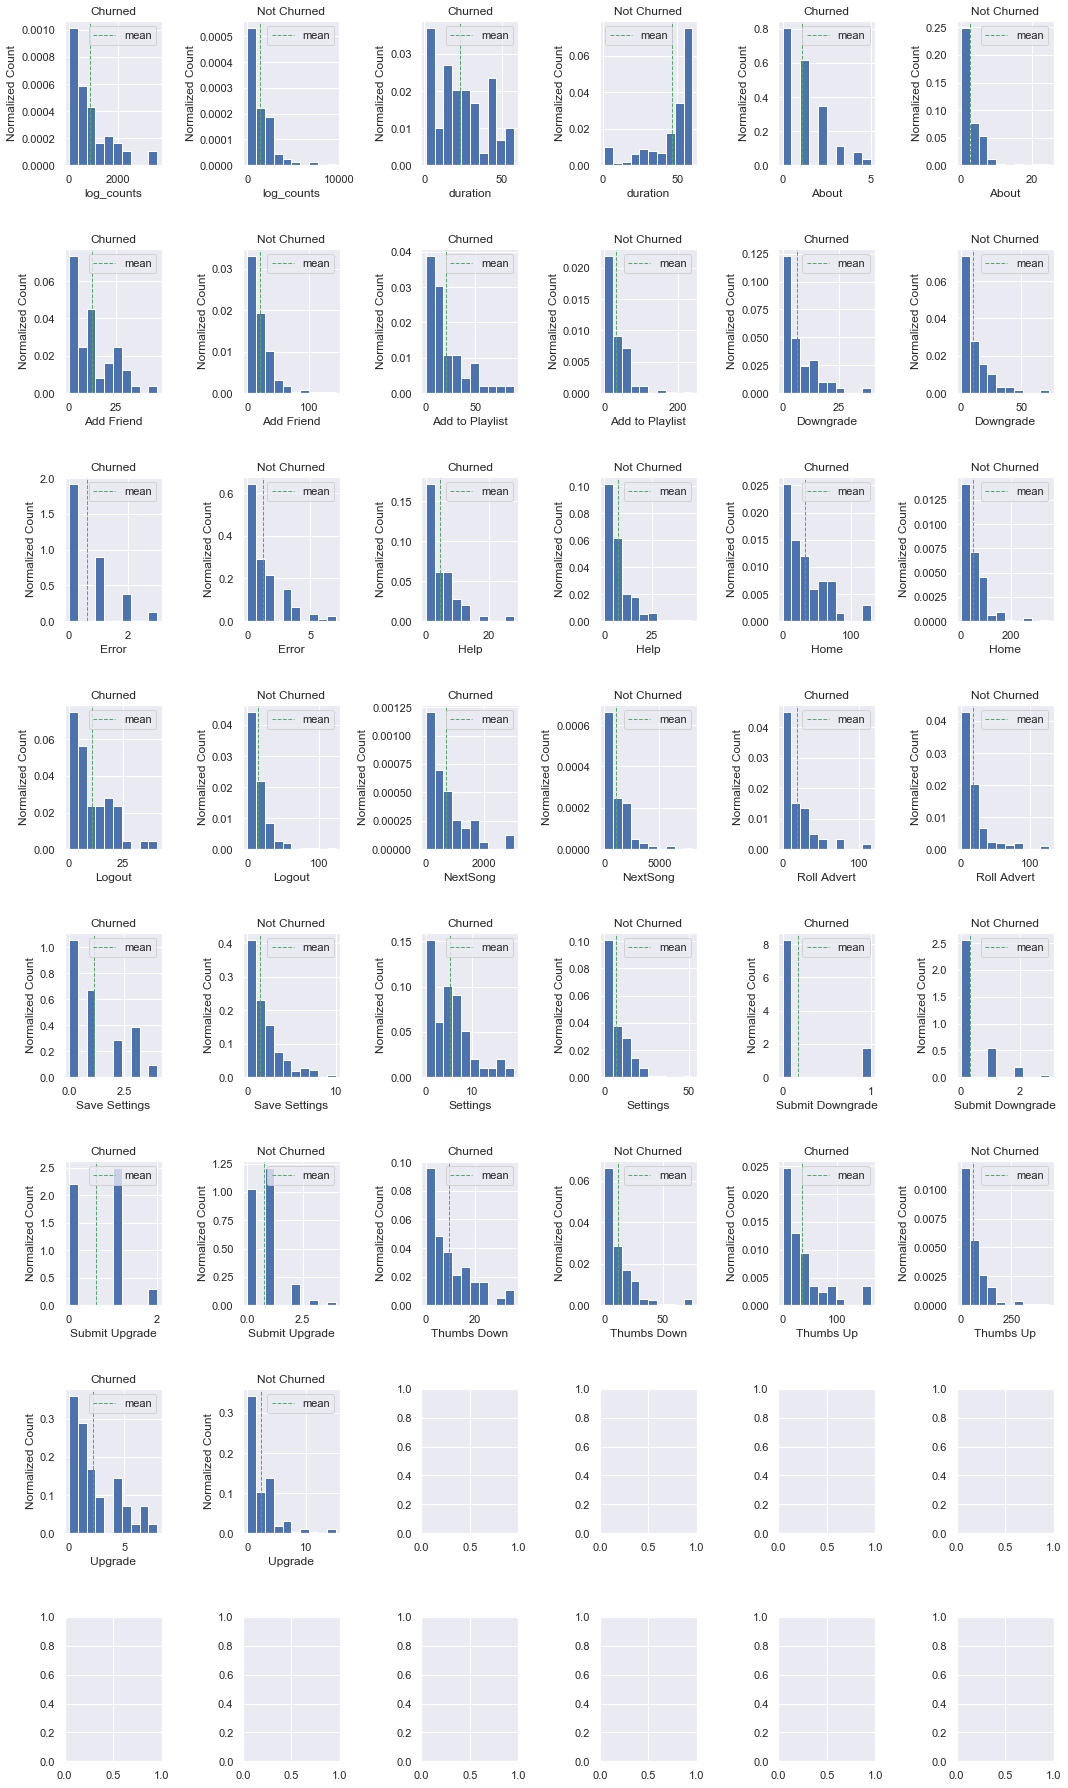

In [112]:
# statistics and plots for the count of the actions
styler = plot_data(churned, not_churned, var_names)

In [118]:
styler

,variable,churn,not_churn,diff,relative_diff
0,log_counts,862.769,1348.5,-485.728,-36.0199
1,duration,23.2115,46.5376,-23.326,-50.123
2,About,1.07692,2.53757,-1.46065,-57.5609
3,Add Friend,12.2308,21.0462,-8.81547,-41.8862
4,Add to Playlist,19.9615,31.7225,-11.761,-37.0746
5,Downgrade,6.48077,9.93064,-3.44987,-34.7396
6,Error,0.615385,1.27168,-0.656292,-51.6084
7,Help,4.59615,7.02312,-2.42697,-34.5568
8,Home,32.1538,48.6127,-16.4589,-33.8571
9,Logout,10.6346,15.4509,-4.81625,-31.1714


Churn Statistics for Dummy Variables
Churn 			 | Not Churn 		 | Diff 		 | Variable
0.001262 		 0.001757 		 -0.000495 		 About_per_log_counts
0.015496 		 0.017133 		 -0.001637 		 Add Friend_per_log_counts
0.022944 		 0.022120 		 0.000825 		 Add to Playlist_per_log_counts
0.005923 		 0.005276 		 0.000647 		 Downgrade_per_log_counts
0.000761 		 0.001031 		 -0.000269 		 Error_per_log_counts
0.004768 		 0.005369 		 -0.000601 		 Help_per_log_counts
0.043738 		 0.040008 		 0.003730 		 Home_per_log_counts
0.013078 		 0.013127 		 -0.000049 		 Logout_per_log_counts
0.768807 		 0.803382 		 -0.034575 		 NextSong_per_log_counts
0.041429 		 0.026964 		 0.014466 		 Roll Advert_per_log_counts
0.001481 		 0.001333 		 0.000148 		 Save Settings_per_log_counts
0.009047 		 0.006478 		 0.002570 		 Settings_per_log_counts
0.000184 		 0.000205 		 -0.000021 		 Submit Downgrade_per_log_counts
0.001074 		 0.000653 		 0.000421 		 Submit Upgrade_per_log_counts
0.012785 		 0.008180 		 0.004605 		 Thumbs Down_per_lo

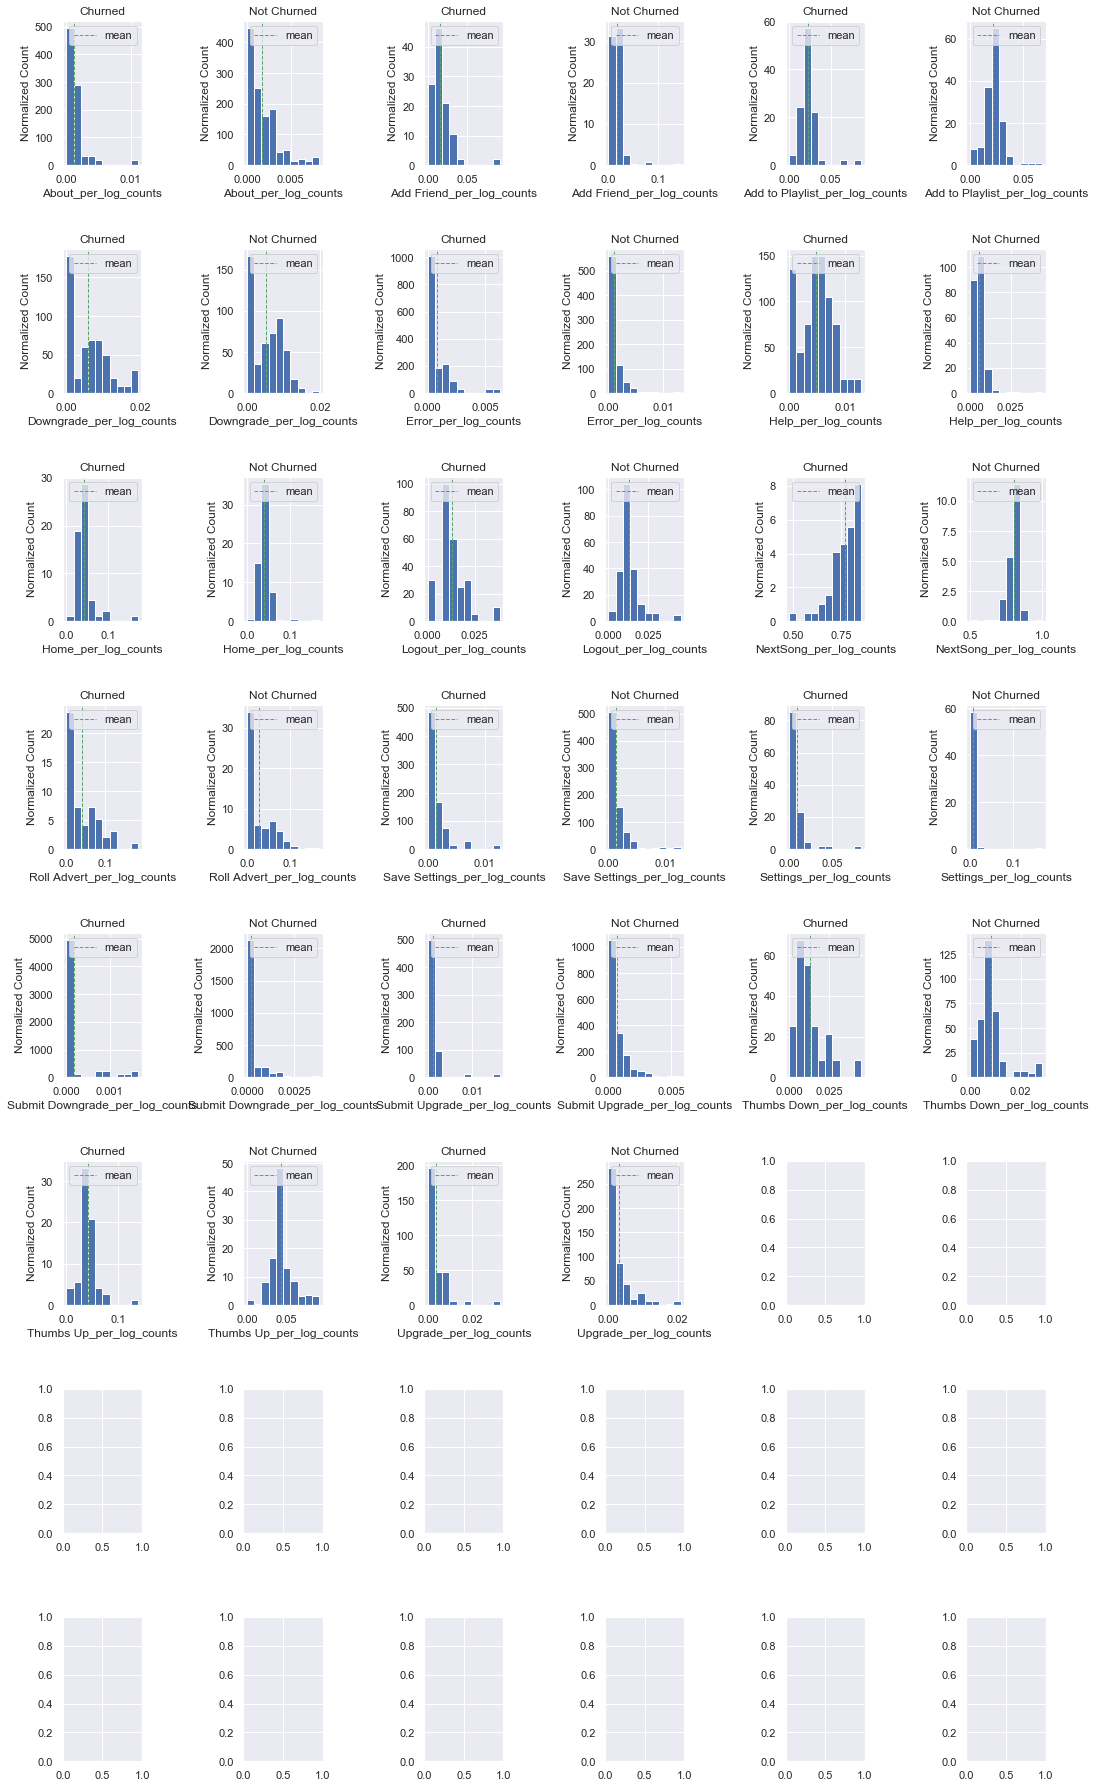

In [125]:
# statistics and plots for the actions per log counts
styler_per_logs = plot_data(churned, not_churned, var_names_per_logs)

In [126]:
styler_per_logs

,variable,churn,not_churn,diff,relative_diff
0,About_per_log_counts,0.00126161,0.00175698,-0.00049537,-28.1944
1,Add Friend_per_log_counts,0.0154962,0.0171334,-0.0016372,-9.55561
2,Add to Playlist_per_log_counts,0.0229444,0.0221196,0.000824762,3.72864
3,Downgrade_per_log_counts,0.00592252,0.00527558,0.000646943,12.263
4,Error_per_log_counts,0.000761369,0.00103085,-0.000269486,-26.142
5,Help_per_log_counts,0.00476767,0.00536916,-0.00060149,-11.2027
6,Home_per_log_counts,0.0437383,0.0400079,0.0037304,9.32414
7,Logout_per_log_counts,0.0130783,0.0131273,-4.90739e-05,-0.373829
8,NextSong_per_log_counts,0.768807,0.803382,-0.0345754,-4.30373
9,Roll Advert_per_log_counts,0.0414293,0.0269637,0.0144656,53.6485


Churn Statistics for Dummy Variables
Churn 			 | Not Churn 		 | Diff 		 | Variable
0.065681 		 0.059088 		 0.006593 		 About_per_duration
0.758482 		 0.481741 		 0.276741 		 Add Friend_per_duration
1.109141 		 0.710358 		 0.398784 		 Add to Playlist_per_duration
0.334350 		 0.197237 		 0.137113 		 Downgrade_per_duration
0.043450 		 0.030080 		 0.013370 		 Error_per_duration
0.247444 		 0.145519 		 0.101925 		 Help_per_duration
1.932297 		 1.102673 		 0.829623 		 Home_per_duration
0.663351 		 0.375776 		 0.287575 		 Logout_per_duration
37.885310 		 24.937608 		 12.947702 		 NextSong_per_duration
1.669263 		 0.474193 		 1.195070 		 Roll Advert_per_duration
0.067932 		 0.044087 		 0.023845 		 Save Settings_per_duration
0.361135 		 0.182987 		 0.178148 		 Settings_per_duration
0.005810 		 0.005661 		 0.000149 		 Submit Downgrade_per_duration
0.030526 		 0.014735 		 0.015790 		 Submit Upgrade_per_duration
0.516094 		 0.262862 		 0.253232 		 Thumbs Down_per_duration
2.016676 		 1.348474 		 0

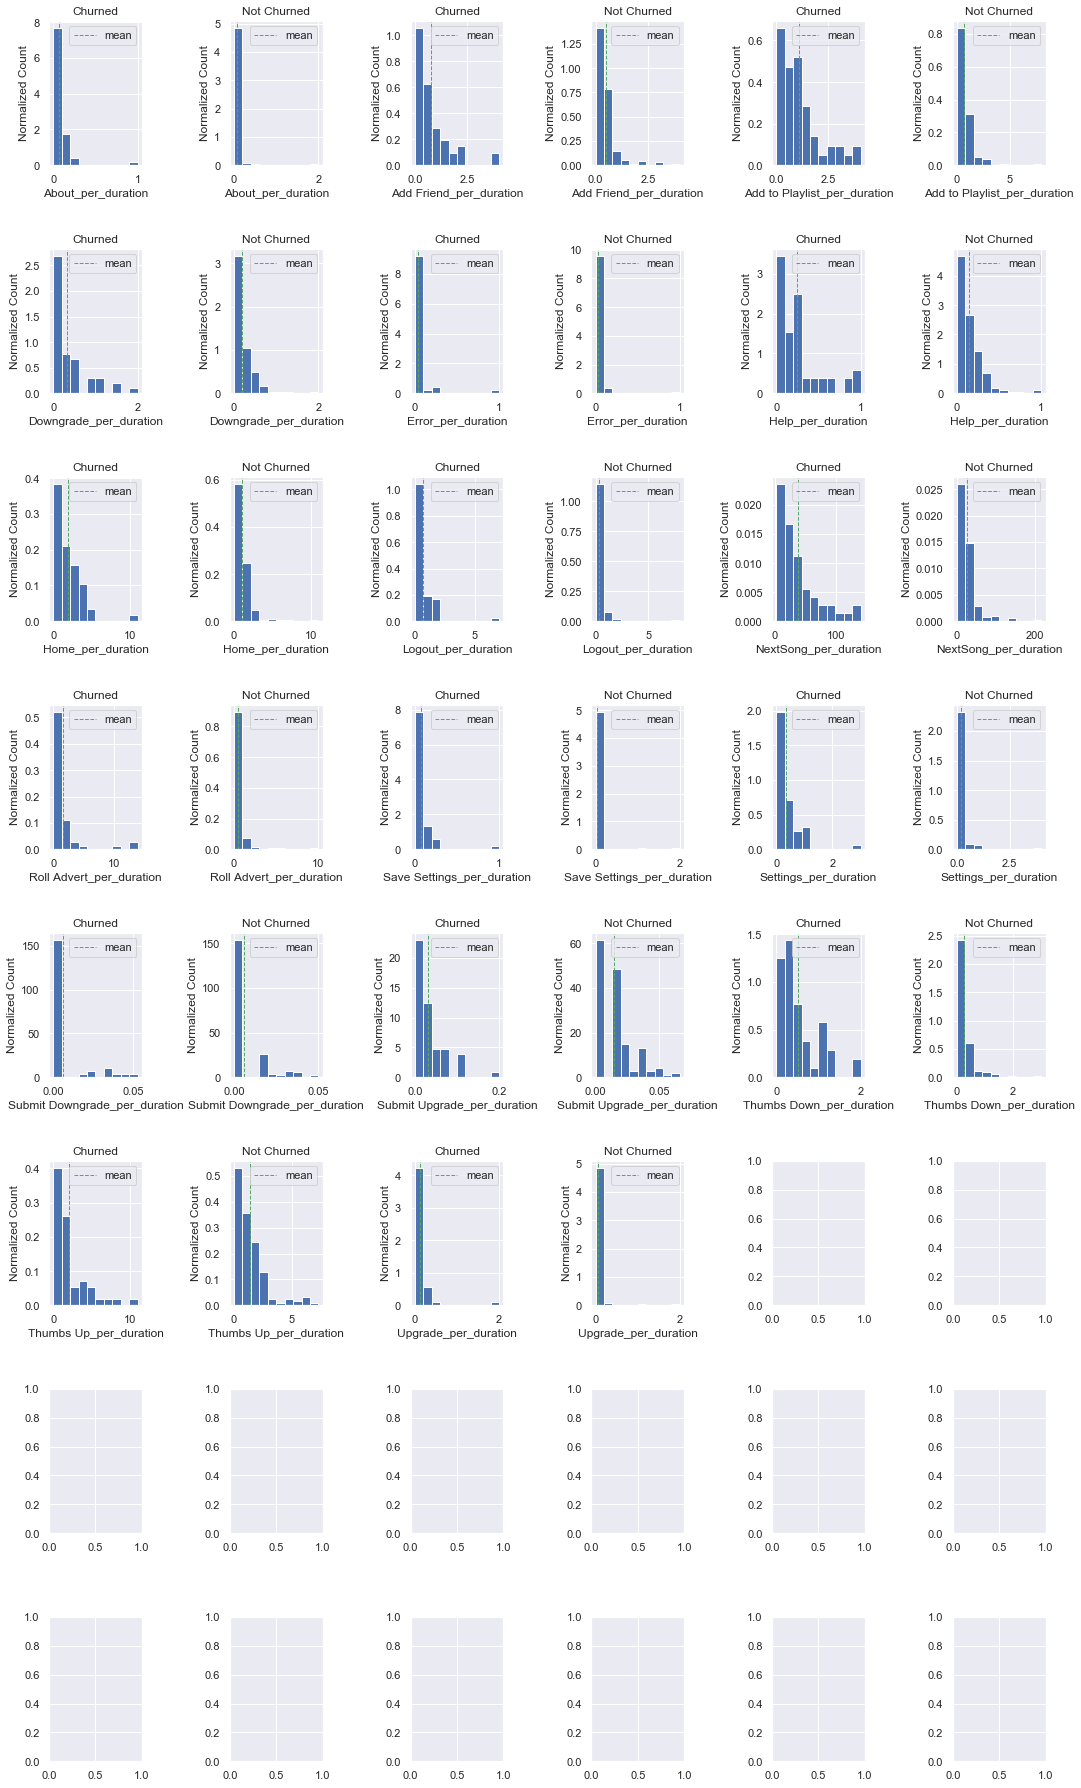

In [133]:
# statistics and plots for the actions per log counts
styler_per_duration = plot_data(churned, not_churned, var_names_per_duration)

In [134]:
styler_per_duration

,variable,churn,not_churn,diff,relative_diff
0,About_per_duration,0.0656807,0.0590879,0.00659287,11.1577
1,Add Friend_per_duration,0.758482,0.481741,0.276741,57.4459
2,Add to Playlist_per_duration,1.10914,0.710358,0.398784,56.1384
3,Downgrade_per_duration,0.33435,0.197237,0.137113,69.5168
4,Error_per_duration,0.0434504,0.03008,0.0133704,44.4494
5,Help_per_duration,0.247444,0.145519,0.101925,70.0419
6,Home_per_duration,1.9323,1.10267,0.829623,75.2375
7,Logout_per_duration,0.663351,0.375776,0.287575,76.5282
8,NextSong_per_duration,37.8853,24.9376,12.9477,51.9204
9,Roll Advert_per_duration,1.66926,0.474193,1.19507,252.022


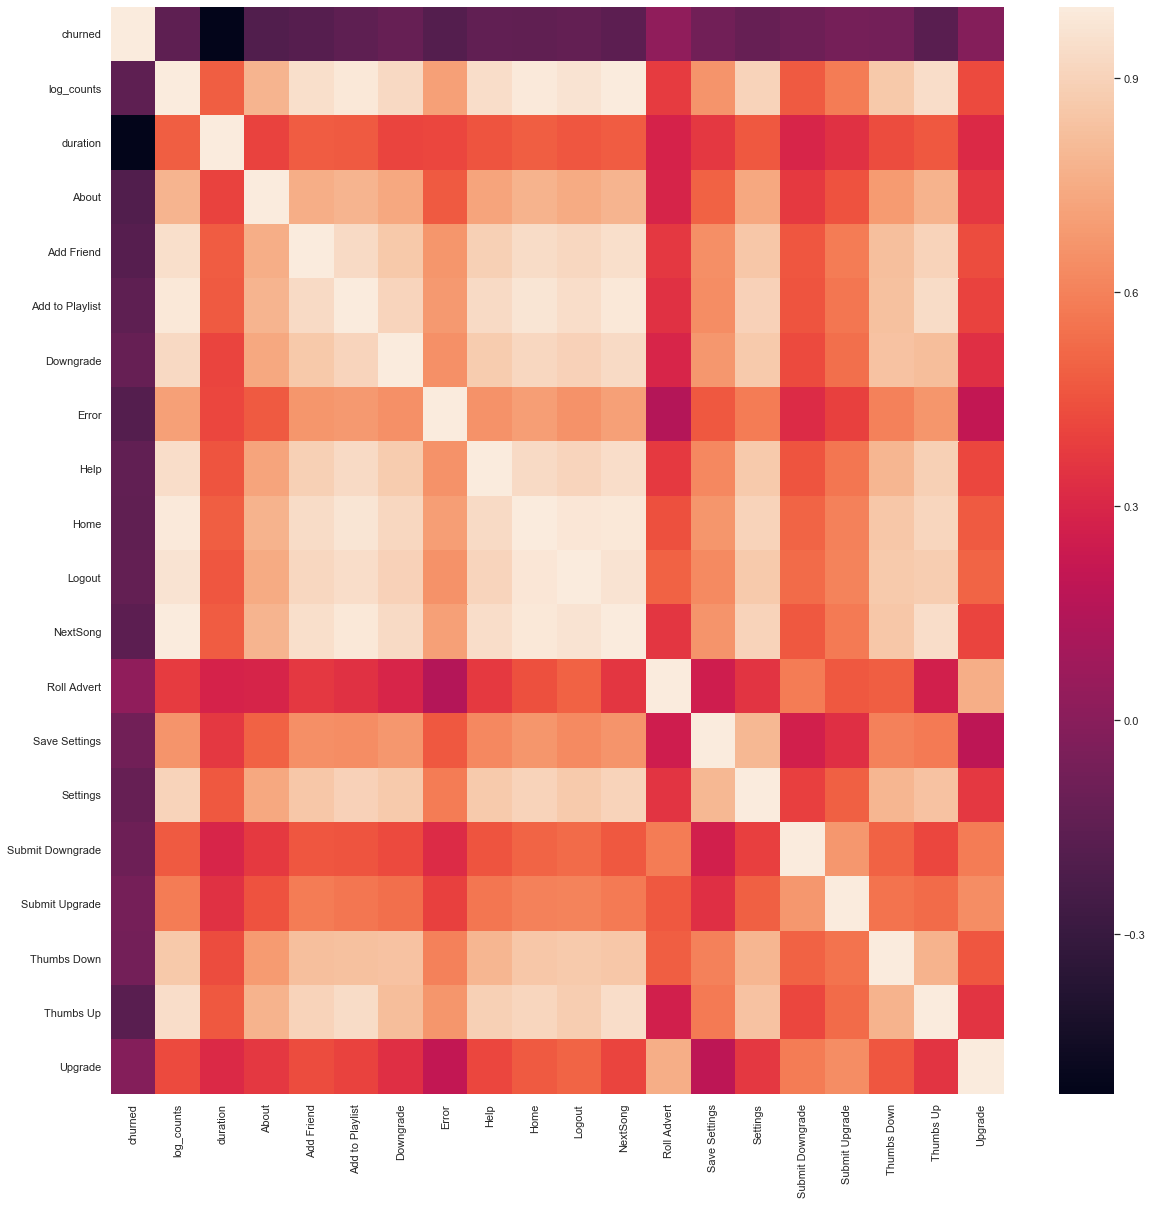

In [149]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(user_pd.corr(), annot=False, fmt='.2f', ax=ax)

In [ ]:
# histogram log events per group -> done above
# gender distribution per group --> just need a histogram for it
# how many days until they churned? assuming last log is cancelled sumbit? --> duration
# level (paid, free) per group --> already done
# 

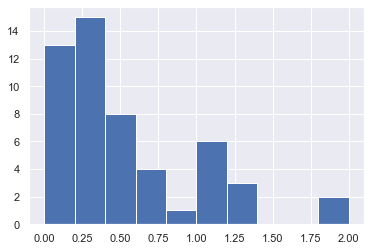

In [135]:
# todo: analytic description of the different histograms, means and deviations (absolute, per_duration, per_logs)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [ ]:
# PCA? eine andere artikel auf dem handy
# downgraded or not
# likes per month or so
# mean, std for the length per each user
# dummy variables for page values
# number of songs played? number of songs played per time?
# how often experienced a specific action in a certain period of time?
# how to handle the errors or 307
# number of sessions
# thumbs up per song


In [ ]:
# customer segmentation might be a solution for later on

In [ ]:
# do not forget numeric features to verify: average length, ...

root
 |-- userId: string (nullable = true)
 |-- churned: long (nullable = true)
 |-- first_log: timestamp (nullable = true)
 |-- last_log: timestamp (nullable = true)
 |-- log_counts: long (nullable = false)
 |-- duration: integer (nullable = true)
 |-- About: long (nullable = true)
 |-- Add Friend: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- Cancel: long (nullable = true)
 |-- Cancellation Confirmation: long (nullable = true)
 |-- Downgrade: long (nullable = true)
 |-- Error: long (nullable = true)
 |-- Help: long (nullable = true)
 |-- Home: long (nullable = true)
 |-- Logout: long (nullable = true)
 |-- NextSong: long (nullable = true)
 |-- Roll Advert: long (nullable = true)
 |-- Save Settings: long (nullable = true)
 |-- Settings: long (nullable = true)
 |-- Submit Downgrade: long (nullable = true)
 |-- Submit Upgrade: long (nullable = true)
 |-- Thumbs Down: long (nullable = true)
 |-- Thumbs Up: long (nullable = true)
 |-- Upgrade: long (nullable = t

In [162]:
user_level = valid_events.select(["userId", "level"]) \
                  .groupBy(["userId", "level"]) \
                  .agg({'level' : 'count'}) \
                  .withColumnRenamed('count(level)', 'count_level')


user_level = user_level.select(["userId", "level", "count_level"]) \
            .groupby("userId") \
            .pivot("level") \
            .agg(F.first("count_level")).na.fill(0)

user_level = user_level.withColumnRenamed("free", "free_logs").withColumnRenamed("paid", "paid_logs")
user_level.show()

+------+---------+---------+
|userId|free_logs|paid_logs|
+------+---------+---------+
|200002|      120|      354|
|100010|      381|        0|
|   125|       11|        0|
|     7|      201|        0|
|   124|        0|     4825|
|    51|        0|     2464|
|    54|      578|     2859|
|    15|        0|     2278|
|   155|      144|      858|
|   132|       34|     2270|
|   154|      118|        0|
|100014|        0|      310|
|    11|      619|      229|
|   101|       76|     2073|
|300017|        0|     4428|
|   138|      262|     2207|
|100021|      319|        0|
|    29|      390|     3213|
|    69|       39|     1303|
|   112|      292|        0|
+------+---------+---------+
only showing top 20 rows



In [210]:
user_gender = valid_events.select(["userId", "gender"]).distinct()
user_gender.show()

+------+------+
|userId|gender|
+------+------+
|    44|     F|
|    46|     F|
|    41|     F|
|    72|     F|
|300023|     F|
|    39|     F|
|100010|     F|
|    40|     F|
|    94|     F|
|    35|     F|
|    75|     F|
|   116|     F|
|200001|     M|
|200020|     M|
|100008|     F|
|200015|     M|
|   100|     M|
|100006|     F|
|300005|     F|
|    25|     F|
+------+------+
only showing top 20 rows



In [174]:
# join user_df (time_df, dummy_df) with user_level and gender_level and user_length
user_df = user_df.join(user_level, on="userId")
user_df = user_df.join(user_gender, on="userId")
user_df = user_df.join(user_length, on="userId")

In [161]:
user_df.where(col("churned") == 0).select("free", "paid").describe().show()

+-------+------------------+------------------+
|summary|              free|              paid|
+-------+------------------+------------------+
|  count|               173|               173|
|   mean|250.47976878612718|1098.0173410404625|
| stddev| 313.8301753317922|1324.5433020478663|
|    min|                 0|                 0|
|    max|              2041|              7779|
+-------+------------------+------------------+



Not sure how to proceed with the level here. Maybe something different than the count for level might be helpful.

In [175]:
user_df.columns

['userId',
 'churned',
 'first_log',
 'last_log',
 'log_counts',
 'duration',
 'About',
 'Add Friend',
 'Add to Playlist',
 'Cancel',
 'Cancellation Confirmation',
 'Downgrade',
 'Error',
 'Help',
 'Home',
 'Logout',
 'NextSong',
 'Roll Advert',
 'Save Settings',
 'Settings',
 'Submit Downgrade',
 'Submit Upgrade',
 'Thumbs Down',
 'Thumbs Up',
 'Upgrade',
 'free_logs',
 'paid_logs',
 'gender',
 'avg_length']

In [171]:
user_df.head()

Row(userId='100010', churned=0, first_log=datetime.datetime(2018, 10, 8, 14, 58, 54), last_log=datetime.datetime(2018, 11, 21, 19, 12, 32), log_counts=381, duration=44, About=1, Add Friend=4, Add to Playlist=7, Cancel=0, Cancellation Confirmation=0, Downgrade=0, Error=0, Help=2, Home=11, Logout=5, NextSong=275, Roll Advert=52, Save Settings=0, Settings=0, Submit Downgrade=0, Submit Upgrade=0, Thumbs Down=5, Thumbs Up=17, Upgrade=2, free=381, paid=0, gender='F', sum(churn)=0, avg_length=243.421444909091, avg_length=243.421444909091, avg_length=243.421444909091)

'About', 'Add Friend', 'Add to Playlist','Downgrade','Error','Help', 'Home', 'Login', 'Logout', 'NextSong', 'Register',
'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade', 'Submit Registration', 'Submit Upgrade', 'Thumbs Down',
'Thumbs Up', 'Upgrade' from the "page".

'gender', 'avg_length', 'free_logs', 'paid_logs'

Later try other features and taking the per_log_counts or per_duration variables.

In [222]:
df = user_df.drop("userId", "first_log", "last_log")
df = df.withColumnRenamed("churned", "label")

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [213]:
from pyspark.ml.feature import RegexTokenizer, CountVectorizer,IDF, StringIndexer,VectorAssembler, Normalizer, StandardScaler;
from pyspark.ml import Pipeline;
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier;
from pyspark.ml.evaluation import MulticlassClassificationEvaluator;
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import OneHotEncoderEstimator

In [223]:
train, validation = df.randomSplit([0.8, 0.2], seed=42)

In [214]:
categorical_column = 'gender'

stringIndexer = StringIndexer(inputCol = categorical_column, outputCol = categorical_column + 'Index')
encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categorical_column + "classVec"])


In [224]:
#create VectorAssembler to push data to ML models
assembler_input = ['About', 'Add Friend', 'Add to Playlist','Downgrade','Error','Help', 'Home', 'Logout', 'NextSong',
'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade', 'Submit Upgrade', 'Thumbs Down',
'Thumbs Up', 'Upgrade', 'genderclassVec', 'avg_length', 'free_logs', 'paid_logs']

assembler = VectorAssembler(inputCols=assembler_input,\
                            outputCol="inputFeatures")

#Lets normalize data
scaler = Normalizer(inputCol="inputFeatures", outputCol="ScaledFeatures")


model_rf = RandomForestClassifier(featuresCol="ScaledFeatures", labelCol="label")

In [225]:
pipeline_rf = Pipeline(stages=[stringIndexer, encoder, assembler, scaler, model_rf]);

In [226]:
"""paramGrid = ParamGridBuilder() \
    .addGrid(model_rf.probabilityCol,['probability']) \
    .addGrid(model_rf.rawPredictionCol,['rawPrediction']) \
    .addGrid(model_rf.seed,[123]) \
    .addGrid(model_rf.predictionCol,['prediction']) \
    .addGrid(model_rf.labelCol,['churned']) \
    .addGrid(model_rf.featuresCol,['ScaledFeatures']) \
    .addGrid(model_rf.maxDepth,[5]) \
    .addGrid(model_rf.maxBins,[32]) \
    .addGrid(model_rf.minInstancesPerNode,[1]) \
    .addGrid(model_rf.minInfoGain,[0.0]) \
    .addGrid(model_rf.maxMemoryInMB,[256]) \
    .addGrid(model_rf.checkpointInterval,[10]) \
    .addGrid(model_rf.impurity,['gini']) \
    .addGrid(model_rf.numTrees,[20]) \
    .addGrid(model_rf.featureSubsetStrategy,['auto']) \
    .addGrid(model_rf.subsamplingRate,[1.0]) \
    .build()"""

paramGrid = ParamGridBuilder() \
        .addGrid(model_rf.numTrees, [20,75]) \
        .addGrid(model_rf.maxDepth, [10, 20]) \
        .build() 


crossval = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=3) # here you can set parallelism parameter

In [227]:
cvModel_rf = crossval.fit(train)

In [243]:
def model_performance(model, test_data, metric = 'f1'):
    """ Calculate Model Scores using f1 metric 
        Input: 
            model- trained model or pipeline object
            metric- the metric used to measure performance
            data - data on which performance measurement should be done
        Output:
            score
    """
    evaluator = MulticlassClassificationEvaluator(metricName = metric)
    prediction_result = model.transform(test_data)
    # find f1 score
    score = evaluator.evaluate(prediction_result)
    #return score
    return score

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [228]:
ParamGridBuilder?

In [240]:
from pyspark.context import SparkContext
sc = SparkContext.getOrCreate()

In [241]:
cvModel_rf.bestModel

TypeError: save() takes 2 positional arguments but 3 were given

In [244]:
model_performance(cvModel_rf.bestModel, validation)

0.6288515406162466